
# Accelerating Monte Carlo

Here we summarize the most relevant results achieved during the project. We provide a brief description of the theretical framework, the code and the plots in order to be as clear as possible.


## Theory

-----



### Model



$$
H(\mathbf{\sigma}) = \sum_{i=1}^{N} J_{ij}\sigma_i\sigma_j
$$
with the couplings strength between spin $i$ and $j$ $J_{ij}\in[-1,1]$ uniformly distributed and $\sigma_i \in \{\pm1\}$. $\mathbf{\sigma} = (\sigma_1, \dots, \sigma_N)$ indicates the spin configuration.
We are interested in the thermodinamic properties such as the average energy $E=\langle H(\mathbf{\sigma})\rangle$ or the magnetization $m=\langle \sum_{i=1}^N{\sigma_i} \rangle$, where the brackets indicate the expectation value over the Boltzmann distribution
$$
P(\mathbf{\sigma}) = \exp{[-\beta H(\mathbf{\sigma})]} / Z, 
$$ 
where $\beta=1/k_BT$ is the inverse temperature, $k_B=1$ the Boltzmann constant, T the temperature and $Z=\sum_{\mathbf{\sigma}}{\exp{[-\beta H(\mathbf{\sigma})]}}$ is the partition function.


### Method



The properties defined above can be computed with a stochastic Markov Chain in the configuration space, driven by by a suitable transition matrix. Each entry of the matrix $T_{\mathbf{\sigma'}\mathbf{\sigma}}$ represent the probability to move from the configuration $\mathbf{\sigma'}$ to $\mathbf{\sigma}$, thus must apply the *datailed balance condition* $T_{\mathbf{\sigma'}\mathbf{\sigma}} \geq 0$ and $\sum_{\mathbf{\sigma'}}{T_{\mathbf{\sigma'}\mathbf{\sigma}}} = 1$ for any $\mathbf{\sigma}$. A common procedure is to decompose $T_{\mathbf{\sigma'}\mathbf{\sigma}} = \omega_{\mathbf{\sigma'}\mathbf{\sigma}}A_{\mathbf{\sigma'}\mathbf{\sigma}}$ for $\mathbf{\sigma'} \neq \mathbf{\sigma}$, where $\omega_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to propose moving from $\mathbf{\sigma}$ to $\mathbf{\sigma'}$ and $A_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to accept the proposed update.

The Metropolis-Hastings algorithm is a way to satisfy the detailed balance condition, where they defined the acceptance probability as 
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).
$$
One can consider a symmertic proposal distribution, as in the single spin-flip algorithm where we chose uniformly a spin $i$ and propose to flip it. In that case the acceptance probability involves only the Boltzmann probability $P(\mathbf{\sigma})$, i.e., $A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{P(\mathbf{\sigma}')}{P(\mathbf{\sigma})}\right)$.


#### Autoregressive Neural Network 



As explained in the paragraph above, we can change the proposal distribution, keeping in mind the detailed balance condition. *Machine Learning* (ML) gives us a possible alternative method. in particular a subclass of Neural Networks (NN), the Autoregressive Neural Networks (ANN) that aim to solve the general problem of the *distribution estimation*. The distribution estimation is the task of estimating a joint distribution $p(\mathbf{x})$ from a set of examples $\{\mathbf{x}^{(t)}\}^T_{t=1}$.
The data generation usually is made sampling a latent state $\mathbf{h}$ from some prior $p(\mathbf{h})$, then sampling the observed data $\bf{x}$ from some conditional $p(\mathbf{x} \mid \mathbf{h})$.

So we introduce a particular ANN, called **M**asked **A**utoregressive **D**ensity **E**stimator (**MADE**), that we will use as a proposal generator for the Markov Chain Monte Carlo (MCMC).

Here and in the following, we consider a training set of examples $\left\{\mathbf{x}^{(t)}\right\}_{t=1}^T$ where each input is a $D$-dimensional array $\mathbf{x} = (x_1, \dots, x_D)$ with $x_d \in \{0,1\}$.
The aim of an autoencoder is to obtain an hidden representation $\bf{h(x)}$ of the input $\bf{x}$, and then obtain a reconstruction $\hat{\mathbf{x}}$ as close as possible to $\mathbf{x}$. Thus we have
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \mathbf{W}\mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \mathbf{V}\mathbf{h}(\mathbf{x})\right),
$$
where $\mathbf{W}$ and $\mathbf{V}$ are matrices, $\mathbf{b}$ and $\mathbf{c}$ are vectors, $g=\text{ReLU}(x)$ and $\sigma(x)=1 / (1 + \exp(-a))$. 
The neural network is trained by minimizing the binary cross-entropy loss function
$$
\ell(\mathbf{x})= \sum_{d=1}^D -x_d\log(\hat{x}_d) -(1-x_d)\log(1-\hat{x}_d).
$$
Treating $\hat{x}_d$ as the probability that $x_d$ is 1, i.e., $p(x_d=1)$, the cross-entropy is nothing more than the negative log-likelihood function. The neural network is then trained optimizing the parameters $\left \{\mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c} \right\}$.

We impose then that the output of the NN can be used as a probabilities. We exploit the so called *autoregressive property*, where each dimension of input $\mathbf{x}$ is predicted sequentially. More precisely, we can decompose the probability into the product 
$$
p(\mathbf{x}) = \prod_{d=1}^{D} p(x_d \mid \mathbf{x}_{<d}),
$$
where $\mathbf{x}_{<d} = \left( x_1, x_2, \dots, x_{d-1} \right)$ is a vector with the first $d$ elements of the input. So, assuming $p(x_d = 1 \mid \mathbf{x}_{<d}) = \hat{x}_d$ and thus $p(x_d = 0 \mid \mathbf{x}_{<d}) = 1 - \hat{x}_d$, the cross-entropy loss function becomes a proper negative log-likelihood
$$
-\log p(\mathbf{x}) = \sum_{d=1}^D -\log p(x_d \mid \mathbf{x}_{<d})= \sum_{d=1}^D -x_d\log p(x_d \mid \mathbf{x}_{<d}) - (1-x_d)\log p(x_d \mid \mathbf{x}_{<d}) = \ell(\mathbf{x}).
$$

In order for the NN to satisfy the autoregressive property, one has to *mask* some connections. In fact, to decompose the probability into a product, the output $\hat{x}_d$  has to be independent from the subsequent inputs $\mathbf{x}_{>d} = \left( x_d, \dots, x_D \right)$, thus the weight matrices ($\mathbf{W}$ and $\mathbf{V}$) must have zeros on the connections that we need to remove. Therefore we define two masks $\mathbf{M^W}$ and $\mathbf{M^V}$ for $\mathbf{W}$ and $\mathbf{V}$ such that
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \left( \mathbf{W} \cdot \mathbf{M^W}\right) \mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \left(\mathbf{V} \cdot \mathbf{M^V}\right) \mathbf{h}(\mathbf{x})\right),
$$
where $\cdot$ indicates the element-wise product.


#### Monte Carlo Algorithms



##### Neural Markov Chain Monte Carlo (N-MCMC) 



We describe here how to use the neural network inside the Monte Carlo algorithm as a smart proposal. We called this procedure *Neural Markov Chain Monte Carlo* (N-MCMC). When using the ANN as a configuration proposal, the Metropolis-Hastings acceptance probability becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.

The dataset needed to train the **MADE** is generated using the [D-Wave](https://www.dwavesys.com/) quantum system. The D-Wave system is a quantum annealer with up to 5000 qubits. An Ising model can be easily mapped into this kind of annealer to perform adiabatic quantum computation to obtain the ground state of $H$. Since we are in NISQ regime, we cannnot expect the D-Wave annealer to *always* sample the ground state, but it provides low-energy configuration, which can be useful to simulate the low-temperature dinamics.

The algorithm run as follows:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo using the ANN as a smart proposal.


##### Hybrid Markov Chain Monte Carlo (N-MCMC)


The *pure* neural MCMC can lead some bias in the estimation of the thermodinamics properties, mostly because the dataset itself has bias to the low-energy regime. Thus for instance, the error in energy estimation is greater the higher the temperature. This iussue can be easily solved, since at high temperature regime the classic algorithms such as the single spin-flip Monte Carlo perform quite well. 

So we exploit both the algorithms, neural and single spin flip, to achieve good performance in every regime. We called this procedure *Hybrid Markov Chain Monte Carlo* (H-MCMC) and it runs as follow:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo:
     - Neural step using the ANN proposal;
     - Classic single spin step.

In our simulation a single spin-flip step is a sweep, i.e., a flip attempt for every spin in the configuration.
The acceptance rate is slightly different, in particular it depends on the type of the next step in the simulation: when the next step is a single spin flip we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')}{p(\mathbf{\sigma})}\right),
$$
though if the next step is a neural one we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$ 
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.


## Results

-----


In [2]:
# imports

from typing import Optional, List, Tuple, Union, Any
import json
import os
import math

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from src.utils.utils import get_energy, compute_energy, get_couplings
#from src.utils.pltutils import plt_betas_ar
from src.utils.montecarlo import neural_mcmc #hybrid_mcmc, seq_hybrid_mcmc, single_spin_flip

plt.style.use('./images/paper.mplstyle')

In [12]:
# plt function TOMOVE in a proper module

def plt_betas_ar(
    acc_rates: List[np.ndarray],
    labels: List[str],
    betas: np.ndarray,
    xlim: Optional[Tuple[float, float]] = None,
    save: bool = False,
):
    fig, ax = plt.subplots() #figsize=(7.2, 6.4), dpi=300

    plt.minorticks_off()


    for i, acc_rate in enumerate(acc_rates):
        plt.plot(betas, acc_rate, "--", label=labels[i])

    if xlim is not None:
        plt.xlim(xlim)

    plt.ylabel(r"$\mathrm{A_r}[\%]$")
    plt.xlabel(
        r"$\mathrm{\beta}$", fontweight="bold"
    )

    plt.legend(loc="best", fancybox=True)

    if save:
        plt.savefig(
            "images/arbeta.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
        )
        plt.savefig(
            "images/arbeta.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
    plt.show()
    return


def plt_eng_step(
    eng1: np.ndarray,
    eng2: np.ndarray,
    label1: str,
    label2: str,
    ground_state: Optional[float] = None,
    xlim: Tuple[int, int] = (1, 100000),
    ylim: Optional[Tuple[int, int]] = None,
    title: Optional[str] = None,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots()

    if len(eng1.shape) > 1: 
        plt.fill_between(
            np.arange(eng1.shape[-1]) + 1,
            eng1.mean(axis=0) + eng1.std(axis=0),
            eng1.mean(axis=0) - eng1.std(axis=0),
            alpha=0.1,
            color="b",
        )
        plt.plot(np.arange(eng1.shape[-1]) + 1, 
                           eng1.mean(axis=0), label=label1, color="b")
    else:
        plt.plot(np.arange(eng1.shape[-1]) + 1, eng1, label=label1, color="b")

    if len(eng2.shape) > 1:
        plt.fill_between(
            np.arange(eng2.shape[-1] + 1),
            eng2.mean(axis=0) + eng2.std(axis=0),
            eng2.mean(axis=0) - eng2.std(axis=0),
            alpha=0.1,
            color="tab:orange",
        )
        plt.plot(np.arange(eng2.shape[-1]) + 1, eng2.mean(0), "--", 
                           label=label2, color="tab:orange", alpha=0.5, linewidth=1.)
    else:
        plt.plot(np.arange(eng2.shape[-1]) + 1, eng2, "--", 
                label=label2, color="tab:orange", alpha=0.5, linewidth=1.)

    if log_scale:
        ax.set_xscale("log")

    if ground_state is not None:
        plt.hlines(
            ground_state,
            xmin=0,
            xmax=xlim[1] + 100000,
            colors="red",
            linestyles="dashed",
            label="Ground State",
            linewidth=3.0,
        )
        if ylim is None:
            ylim = (ground_state - 0.01, max(eng1.max(), eng2.max()))
            plt.ylim(ylim)
        else:
            plt.ylim(ylim)

    plt.xlim(xlim)

    plt.ylabel(r"$E/N$", fontfamily='serif')
    plt.xlabel(r"$\mathrm{\tau}$")

    if title is not None:
        plt.title(rf"{title}", fontsize=20)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        # TOFIX
        # ERROR: when saving .png
        plt.savefig(
            "images/energy-steps.png",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )
        plt.savefig(
            "images/energy-steps.eps",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
    plt.show()
    return


def plt_acf(
    acs1: Union[np.ndarray, List[np.ndarray]],
    label1: Union[str, List[str]],
    acs2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    xlim: Tuple[int, int] = (1, 5000),
    ylim: Tuple[int, int] = (0.01, 1),
    title: Optional[str] = None,
    fit: bool = False,
    log_scale: bool = True,
    save: bool = False,
):
    
    from scipy.optimize import curve_fit

    def stretch_exp(t, a, tau, alpha):
        return a * np.exp(-((t / tau) ** alpha))

    fig, ax = plt.subplots()

    # HARDCODE: to change if we have 
    # more than 3 acs 
    color_acs1 = ["gold", "red", "darkred"]
    if isinstance(acs1, list):
        assert len(acs1) == len(label1)
        assert len(acs1) <= 3

    for i, acs in enumerate(acs1):
        plt.plot(np.arange(xlim[1]) + 1, acs[:xlim[1]], label=label1[i], color=color_acs1[i])
        ax.set_yscale("log")
        if fit:
            p, _ = curve_fit(
                stretch_exp,
                np.arange(xlim[1]),
                acs[:xlim[1]],
                bounds=([-np.inf, 0, 0], [np.inf, np.inf, np.inf]),
            )
            print(f"{label1[i]} a={p[0]} tau*={p[1]} alpha={p[2]}")
            plt.plot(
                np.arange(xlim[1]) + 1,
                stretch_exp(np.arange(xlim[1]), p[0], p[1], p[2]),
                "--",
                color=color_acs1[i],
            )

    if acs2 is not None:
        assert len(acs2) <= 3
        color_acs2 = ["skyblue","steelblue","blue"]
        for i, acs in enumerate(acs2):
            plt.plot(np.insert(acs, 0, 1., axis=0), "--", label=label2[i], color=color_acs2[i])

    if log_scale:
        ax.set_xscale("log")

    plt.ylabel(r"$\mathrm{c(\tau)}$")
    plt.xlabel(r"$\mathrm{\tau}$")

    plt.ylim(ylim)
    plt.xlim(xlim)

    if title is not None:
        plt.title(title, fontsize=18,)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        plt.savefig("images/correlation.png", facecolor=fig.get_facecolor())
        plt.savefig("images/correlation.eps", format="eps")

    plt.show()


def plot_hist(
    paths: List[str],
    couplings_path: str,
    truth_path: str,
    ground_state: Optional[float] = None,
    colors: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    density: bool = False,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    num_bins: int = 50,
    save: bool = False,
) -> None:

    if labels is None:
        labels = [f"Dataset {i}" for i, _ in enumerate(paths)]
        labels.append("Truth")
    if colors is None:
        colors = [None for _ in paths]

    assert len(labels) - 1 == len(colors) == len(paths)

    truth = np.load(truth_path)
    try:
        truth = truth["sample"]
    except:
        truth = truth

    min_len_sample = truth.shape[0]
    truth = np.reshape(truth, (min_len_sample, -1))
    spins = truth.shape[-1]

    # laod couplings
    # TODO Adjancecy should wotk with spins, not spin side
    neighbours, couplings, len_neighbours = get_couplings(
        int(math.sqrt(spins)), couplings_path
    )

    eng_truth = []
    for t in truth:
        eng_truth.append(compute_energy(t, neighbours, couplings, len_neighbours))
    eng_truth = np.asarray(eng_truth) / spins

    min_eng, max_eng = eng_truth.min(), eng_truth.max()

    engs = []
    for path in paths:
        data = np.load(path)
        try:
            sample = data["sample"]
        except:
            sample = data

        sample = sample.squeeze()
        min_len_sample = min(min_len_sample, sample.shape[0])
        sample = np.reshape(sample, (-1, spins))

        eng = []
        for s in sample:
            eng.append(compute_energy(s, neighbours, couplings, len_neighbours))
        eng = np.asarray(eng) / spins

        min_eng = min(min_eng, eng.min())
        max_eng = max(max_eng, eng.max())
        engs.append(eng)

    fig, ax = plt.subplots(figsize=(7.8, 7.8))#, dpi=128, facecolor="white")

    ax.set_yscale("log")

    plt.ylabel("Count", fontweight='normal')
    plt.xlabel(r"$E/N$")

    plt.ylim(1, min_len_sample * 0.5)

    bins = np.linspace(min_eng, max_eng, num=num_bins).tolist()

    for i, eng in enumerate(engs):
        _ = plt.hist(
            eng[:min_len_sample],
            bins=bins,
            label=f"{labels[i]}",
            histtype="bar",
            linewidth=0.1,
            edgecolor=None,
            alpha=0.9 - i * 0.1,
            color=colors[i],
            density=density,
        )
        print(
            f"\n{labels[i]}\nE: {eng.mean()} \u00B1 {eng.std(ddof=1) / math.sqrt(eng.shape[0])}\nmin: {eng.min()} ({np.sum(eng==eng.min())} occurance(s))                                                                    (s))"
        )
    _ = plt.hist(
        eng_truth[:min_len_sample],
        bins=bins,
        # log=True,
        label=f"{labels[i+1]}",
        histtype="bar",
        edgecolor="k",
        color=["lightgrey"],
        alpha=0.5,
        density=density,
    )

    if density:
        min_len_sample = 200

    if ground_state is not None:
        plt.vlines(
            ground_state,
            1,
            min_len_sample * 0.5,
            linewidth=4.0,
            colors="red",
            linestyles="dashed",
            alpha=0.7,
            label="Ground State",
        )

    print(
        f"\n{labels[i+1]} eng\nE: {eng_truth.mean()} \u00B1 {eng_truth.std(ddof=1) / math.sqrt(eng_truth.shape[0])}\nmin: {eng_truth.min()}  ({np.sum(eng_truth==eng_truth.min())} occurance(s))"
    )

    plt.ylim(1, min_len_sample * 0.5)
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)

    plt.legend(loc="upper right")

    if save:
        plt.savefig("images/hist.png")
        plt.savefig("images/hist.eps", format="eps")

    return


def block_single_std(engs: np.ndarray, len_block: int, skip: int = 0) -> float:
    """Compute the block std of a list of arrays.
    See http://chimera.roma1.infn.it/SP/doc/estratti/dataAnalysis.pdf

    Args:
        engs (np.ndarray): List of energies arrays or array.
        len_block (int): Block lenght to compute std.
        skip (int, optional): Number of initial sample to skip. Defaults to 0.

    Returns:
        float: Block std.
    """
    std_engs = []
    for i in range(engs.shape[0]):
        eng_seed = engs[i]
        error = []
        for eng in eng_seed:
            if isinstance(eng, list):
                eng = np.asarray(eng)
            eng = eng[skip:].copy()
            rest_len = eng.size % len_block
            if rest_len != 0:
                eng = eng[:-rest_len]
            eng = eng.reshape(-1, len_block)
            new_len = eng.shape[0]
            #if new_len < 100:
            #    print(f"WARNING: New Len={new_len} < 100")
            error.append(np.std(eng.mean(axis=1), ddof=0) / np.sqrt(new_len - 1))
        std_engs.append(error)
    return std_engs


def block_std(engs: List[Any], len_block: int, skip: int = 0) -> float:
    """Compute the block std of a list of arrays.
    See http://chimera.roma1.infn.it/SP/doc/estratti/dataAnalysis.pdf

    Args:
        engs (List[Any]): List of energies arrays.
        len_block (int): Block lenght to compute std.
        skip (int, optional): Number of initial sample to skip. Defaults to 0.

    Returns:
        float: Block std.
    """
    std_engs = []
    for eng in engs:
        if isinstance(eng, list):
            eng = np.asarray(eng)
        eng = eng[skip:].copy()
        rest_len = eng.size % len_block
        if rest_len != 0:
            eng = eng[:-rest_len]
        eng = eng.reshape(-1, len_block)
        new_len = eng.shape[0]
        if new_len < 100:
            print(f"WARNING: New Len {new_len} < 100")
        error = np.std(eng.mean(axis=1), ddof=0) / np.sqrt(new_len - 1)
        std_engs.append(error)
    return std_engs

def get_errorbar(energies: np.ndarray, len_block: int, skip: int) -> np.ndarray: 
    yerr = block_single_std(energies, len_block=len_block, skip=skip)
    new_err = [
           np.abs(np.min(energies[..., skip:].mean(axis=2) - yerr - energies[..., skip:].mean(axis=2).mean(0), axis=0)),
           np.abs(np.max(energies[..., skip:].mean(axis=2).mean(0) - (energies[..., skip:].mean(axis=2) + yerr), axis=0))
           ]
    return np.asarray(new_err)


def plt_eng_chains(engs: List[np.ndarray], strengths: np.ndarray, ground_state: float, 
                   dwave_default: float, title: str, xlim: Tuple[float, float] = (0.4, 4.1), 
                   save: bool = False,
                   ) -> None:

    plt.plot(strengths, engs.min(1) / 484, "-s", label=r"Minimum", linewidth=1.)
    plt.errorbar(strengths, engs.mean(1) / 484, engs.std(1) / 484, capsize=5., elinewidth=2.5, linewidth=.5, 
                marker='s', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2, label=r"Mean")

    plt.hlines(ground_state, xmin=xlim[0]-.4, xmax=xlim[1]+.4, colors='red', linestyles='dashed', 
            label="Ground State", linewidth=3)

    if dwave_default is not None and title is not None:
        plt.plot(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").min() / 484,
                "d", color='tab:green', label=f"D-Wave default")
        plt.errorbar(dwave_default, np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").mean() / 484, 
                    np.load(f"data/sweep_chains_{title.lower()}/dwave-engs_0.npy").std() / 484, capsize=5., 
                    elinewidth=1.5, linewidth=.1, marker='d', color='tab:green', fillstyle='none', markersize=8, 
                    markeredgewidth=2, label=f"D-Wave default")

    plt.minorticks_off()
    plt.xlim(xlim)

    plt.ylabel(r"$\mathrm{E}$")
    plt.xlabel(r"chains_strength", fontsize=24, fontweight='ultralight')

    plt.title(f"{title} couplings",  fontsize=20)

    plt.legend(loc='best', fontsize=22, labelspacing=0.4, borderpad=0.2, fancybox=True)
    if save:
        plt.savefig(f"images/strenght-energy_1nn-{title}.png")

        plt.savefig(f"images/strenght-energy_1nn-{title}.eps")

    plt.show()
    


### Ising model 484 spins and 1NN couplings

Here and in the following we focuse on a fixed size and a particular disordered realization, which we saved in a .txt file.

In [3]:
spin_side = 22
spins = spin_side**2
couplings_path_1nn = "data/couplings/484spins-uniform-1nn.txt"
ground_state_1nn = -0.7550297905


#### Load the data


In [4]:
dwave_datasets_1nn = [
    "data/datasets/484-1nn-uniform-1mus/train-484spins-1nn-uniform-1mus.npy",
    "data/datasets/484-1nn-uniform-10mus/train-484spins-1nn-uniform-10mus.npy",
    "data/datasets/484-1nn-uniform-100mus/train-484spins-1nn-uniform-100mus.npy"
    ]

In [5]:
made_data_1nn = [
"data/generated/sample-1000000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
"data/generated/sample-1000000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
"data/generated/sample-1000000_size-484_2022-06-07_18-57-46.npz"  # 100mus&1<beta<2.5 1nn
]

labels_1nn = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
          r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
        ]

In [6]:
parent_path_1nn = "data/hybrid/1nn_100mus_betas10-40/"
hybrid_paths_1nn = sorted(os.listdir(parent_path_1nn))
hybrid_paths_1nn = [parent_path_1nn + path for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = [np.load(path)['energy'] / spin_side**2 for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = np.asarray(eng_seq_hybrid_1nn)

In [11]:
# seed for starting point of mcmc simulations
seeds = [12345, 23451, 34512, 45123, 51234]
betas = [2.0, 2.5, 3.0] # we use some significant temperatures only
single_engs_1nn = []
for seed in seeds:
    paths = []
    for beta in betas:
        paths.append(f"1nn-forpaper/484spins-seed{seed}-sample1000000-beta{str(beta)}.npy")
    single_engs_1nn.append(get_energy(22, paths, couplings_path_1nn))
single_engs_1nn = np.asarray(single_engs_1nn)

In [8]:
# load all the energies for beta in [1,5]
single_engs_long_1nn = np.load("data/energy_beta10-50_1nn-uniform.npy")


#### Acceptance Rate vs $t_A$

Acceptance rate, i.e. $A_{\sigma, \sigma'}$ in the Neural Markov Chain Monte Carlo (N-MCMC) guided by the Autoregressive Neural Network (ANN), at different $\beta$. the ANN is trained using the D-Wave dataset with annealing time $t_A=100 \mu s$.
 

In [ ]:
betas_1nn = np.linspace(0.1, 5, num=50)

acc_rates = []
for i, dataset in enumerate(made_data_1nn):
    acc_rate = []
    if i > 2:
        continue
    for beta in betas_1nn:
        _, _, ar = neural_mcmc(beta, 100000, dataset, couplings_path_1nn, "made", disable_bar=False)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels_1nn):
    if i>2:
        continue
    labels_ar.append(label)

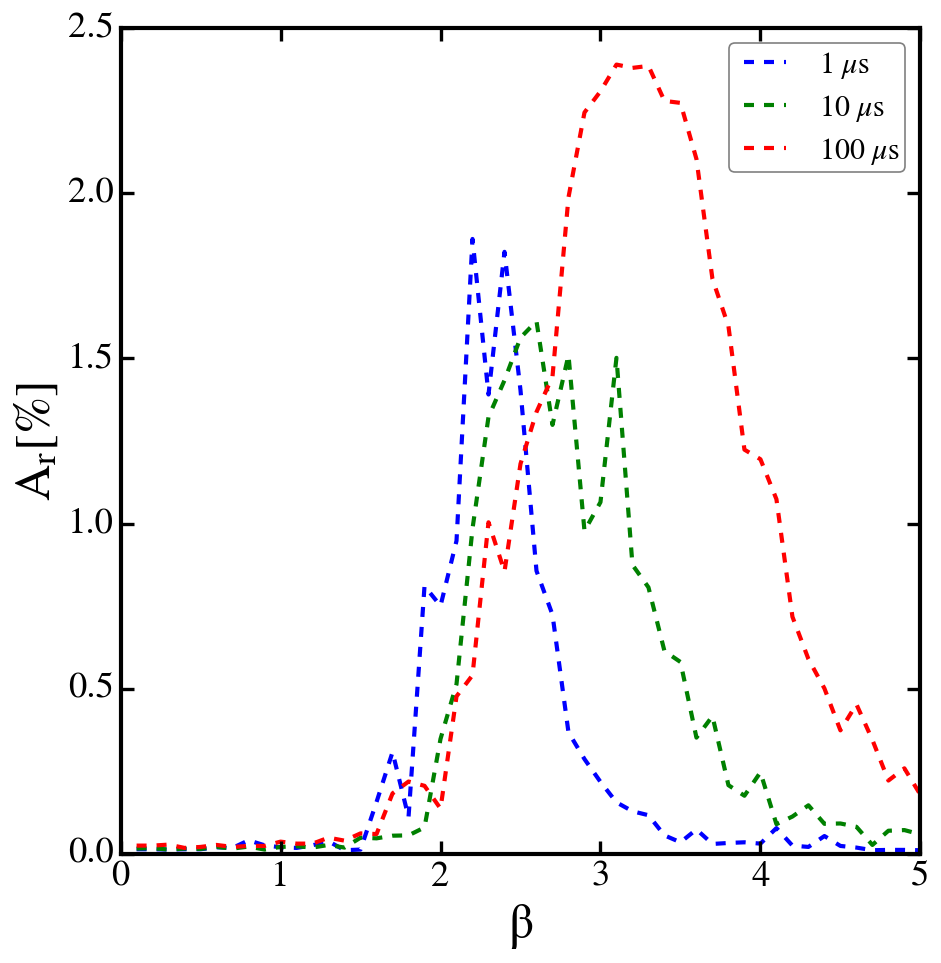

In [110]:
plt_betas_ar(acc_rates, labels_ar, betas_1nn, save=False)


#### Energy vs Steps

Average energy per spin $E/N$ as a function of Monte Carlo steps. The Hybrid Markov Chain Monte Carlo (H-MCMC) thermalizes much faster w.r.t the single spin-flip MCMC. Here for the single spin-flip MCMC we considered a step $\tau$ as a single sweep, for the H-MCMC a step is composed by a sweep and a neural proposal. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


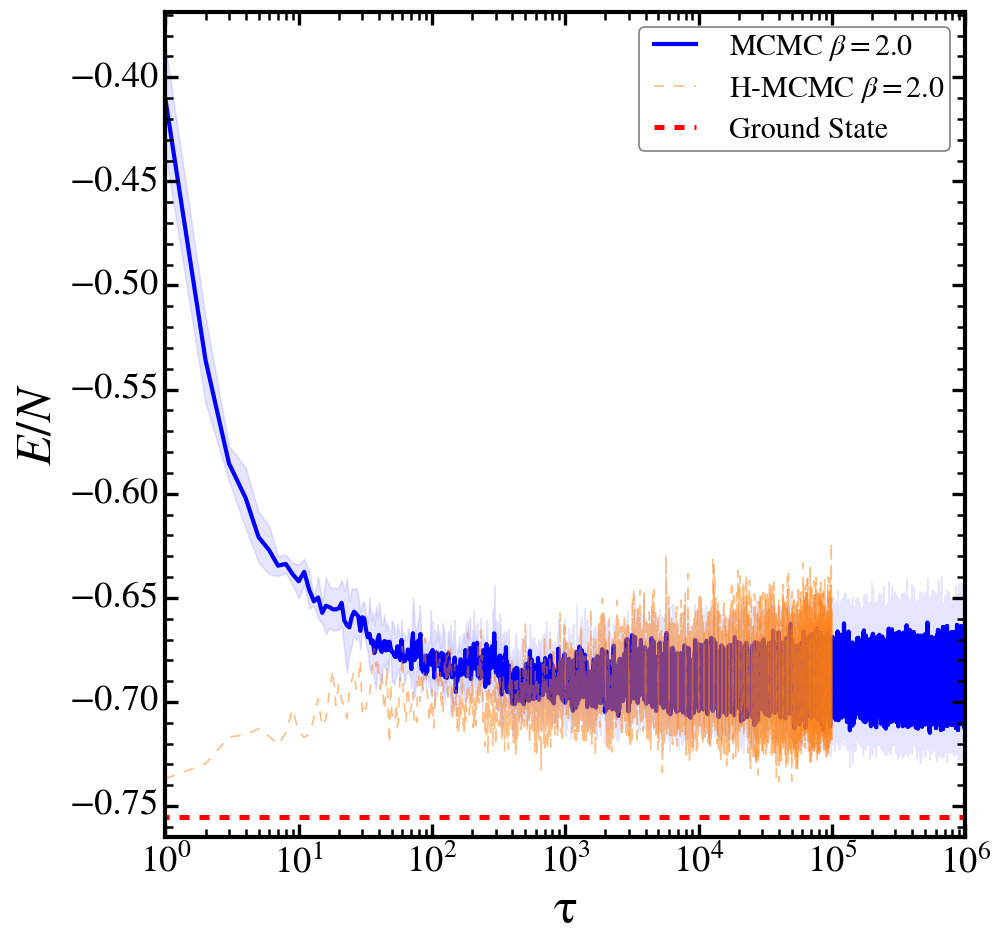

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


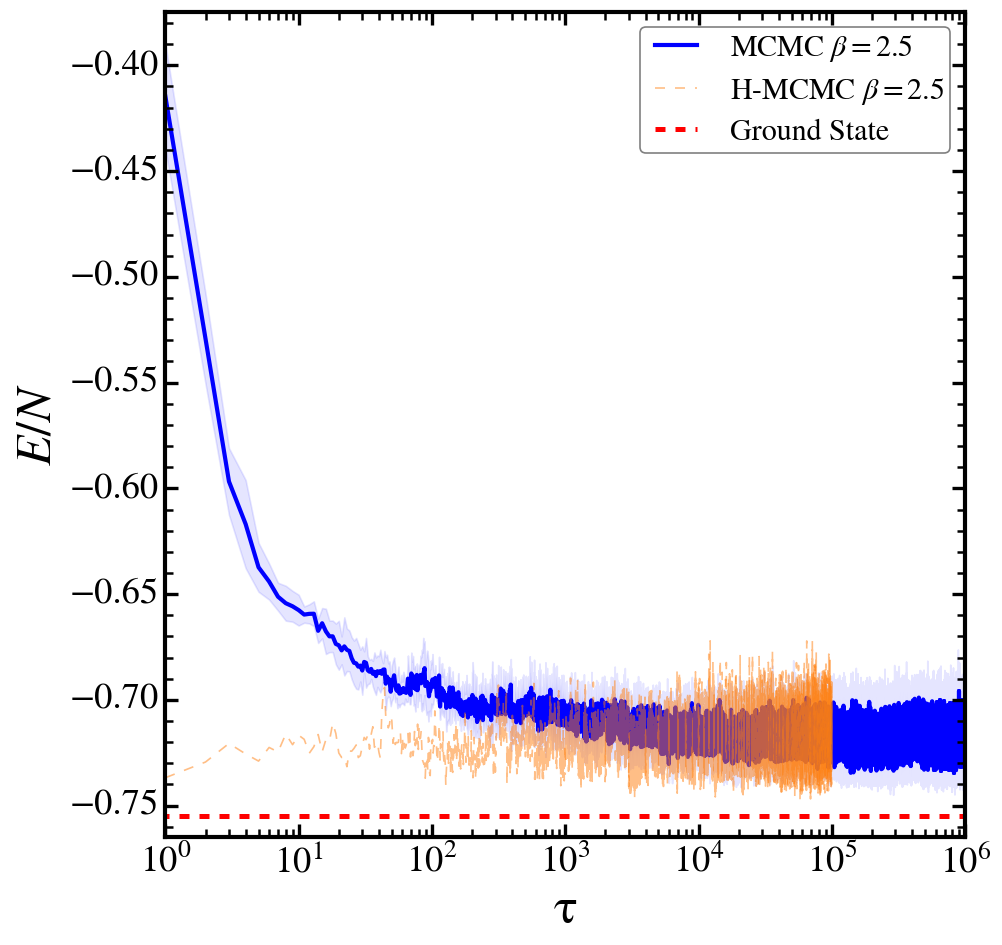

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


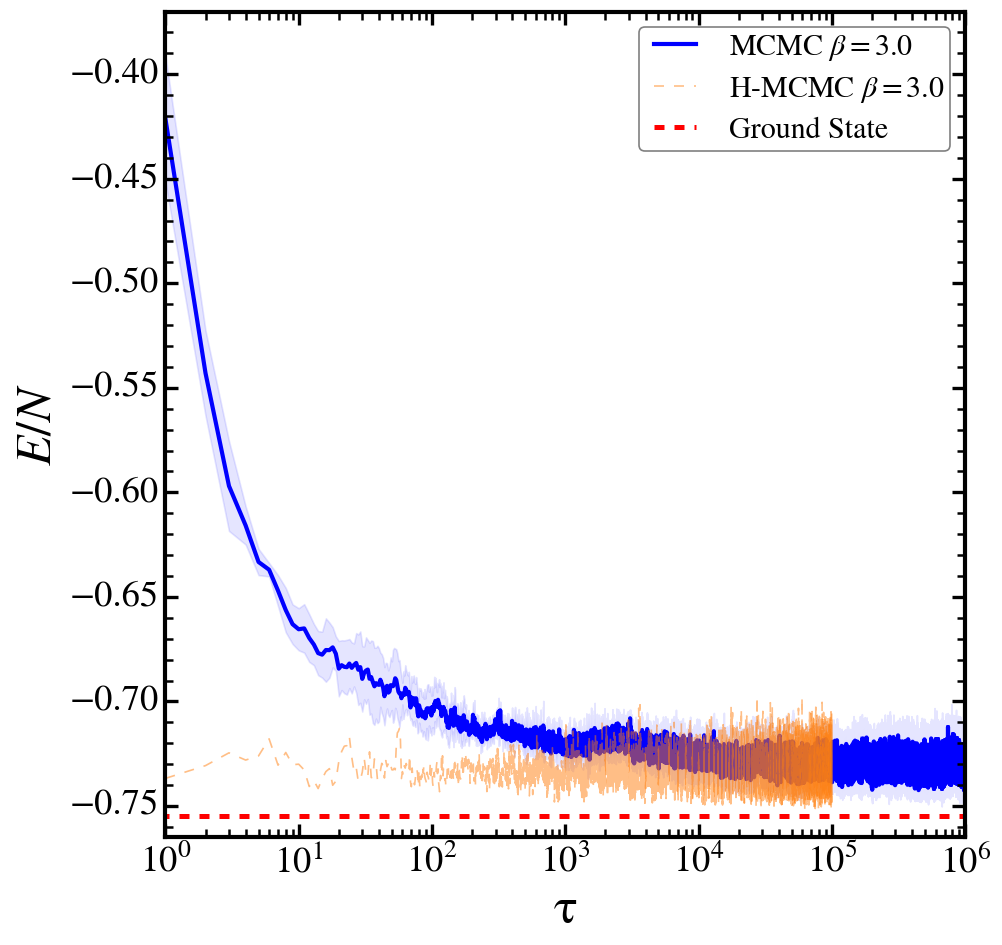

In [7]:
idxs = [10, 15, 20] # valid index in hybrid-MCMC

for i, idx in enumerate(idxs):
    if i!=1:
        pass #continue
    plt_eng_step(single_engs_1nn[:,i], eng_seq_hybrid_1nn[idx, :100000], 
        rf"MCMC $\beta={betas[i]}$", rf"H-MCMC $\beta={betas[i]}$", 
        ground_state=ground_state_1nn, xlim=(1, 1000000), save=True)


#### Autocorrelation vs MCMC Steps (log scale)

 The plot shows the autocorrelations $c(\tau)$ in log-scale measured for different simulations, single spin-flip and hybrid, both performed at three challenging temperatures. On one hand, the correlations of the single spin-flip MCMC increase as the $\beta$ increases, on the other hand, the H-MCMC correlations are stably one or two orders of magnitude lower. In the $x$ axis $\tau$ is a sweep for MCMC and a sweep plus a neural step for H-MCMC.

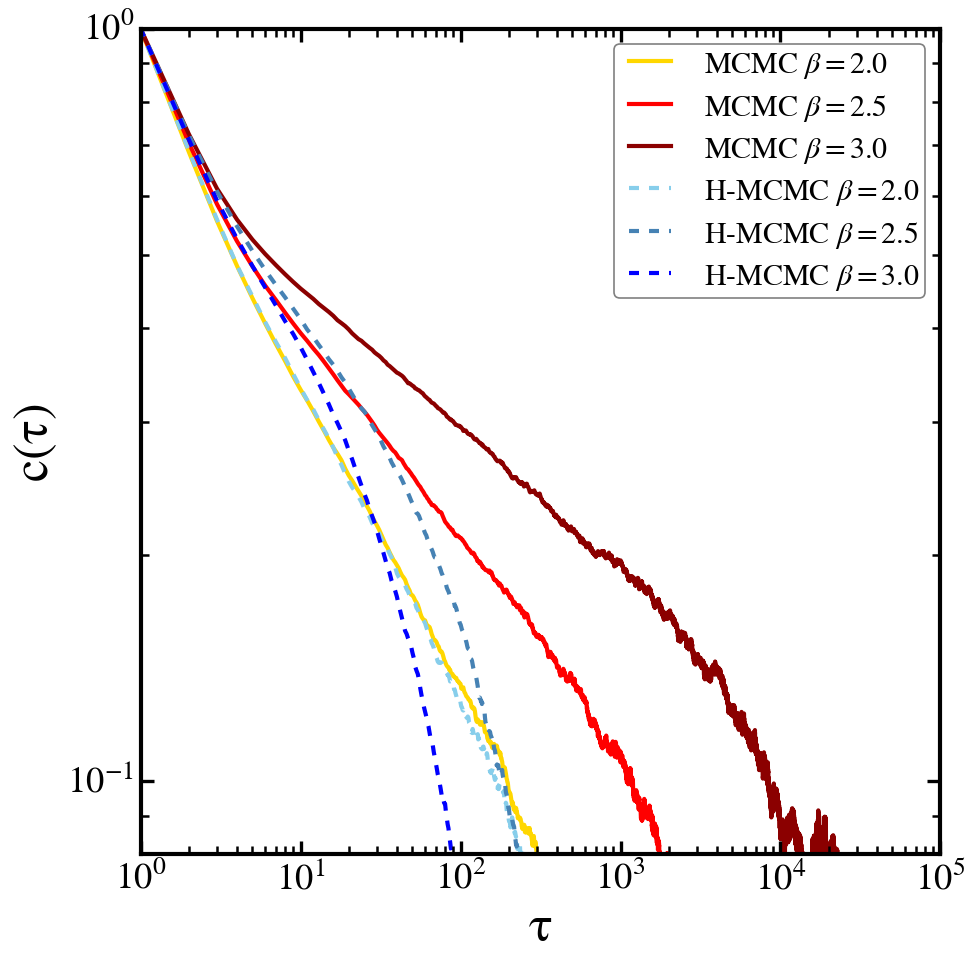

In [18]:
skip=100000 #skip the first samples, used for thermalization
idxs = [10, 15, 20] # valid index in hybrid-MCMC

ac_betas_1nn = []
ac_hybrid = []
for i, idx in enumerate(idxs):
    ac_betas_1nn.append(acf(single_engs_1nn[0,i,skip:], nlags=50000, fft=True))
    ac_hybrid.append(acf(eng_seq_hybrid_1nn[idx], nlags=50000, fft=True))

plt_acf(
    [ac_betas_1nn[0], ac_betas_1nn[1], ac_betas_1nn[2]], 
    [r"MCMC $\beta=2.0$", r"MCMC $\beta=2.5$", r"MCMC $\beta=3.0$"], 
    [ac_hybrid[0], ac_hybrid[1], ac_hybrid[2]], 
    [r"H-MCMC $\beta=2.0$", r"H-MCMC $\beta=2.5$", r"H-MCMC $\beta=3.0$"], 
    ylim=(0.08, 1), 
    xlim=(1, 100000), 
    save=False
)


#### Autocorrelation vs MCMC Steps

Autocorrelations as a function of Monte Carlo steps. For a single spin-flip Monte Carlo the correlation time increases when simulating lower temperature regime. At $\beta > 2$ they start to become infeasible. The fit has been done with a stretch exponential function, $\hat{c}(\tau) = a\exp([-(\tau/\tau^*)^\alpha])$, where $a, \tau^* \text{ and } \alpha$ are fitted parameters.

$\beta=2.0$ a=1.0335148840356845 tau*=5.664998129692427 alpha=0.2435722132155389
$\beta=2.5$ a=1.0387053738891863 tau*=8.471841607387688 alpha=0.17580772249579424
$\beta=3.0$ a=1.0599455821317434 tau*=16.63103869740536 alpha=0.1311628716108515


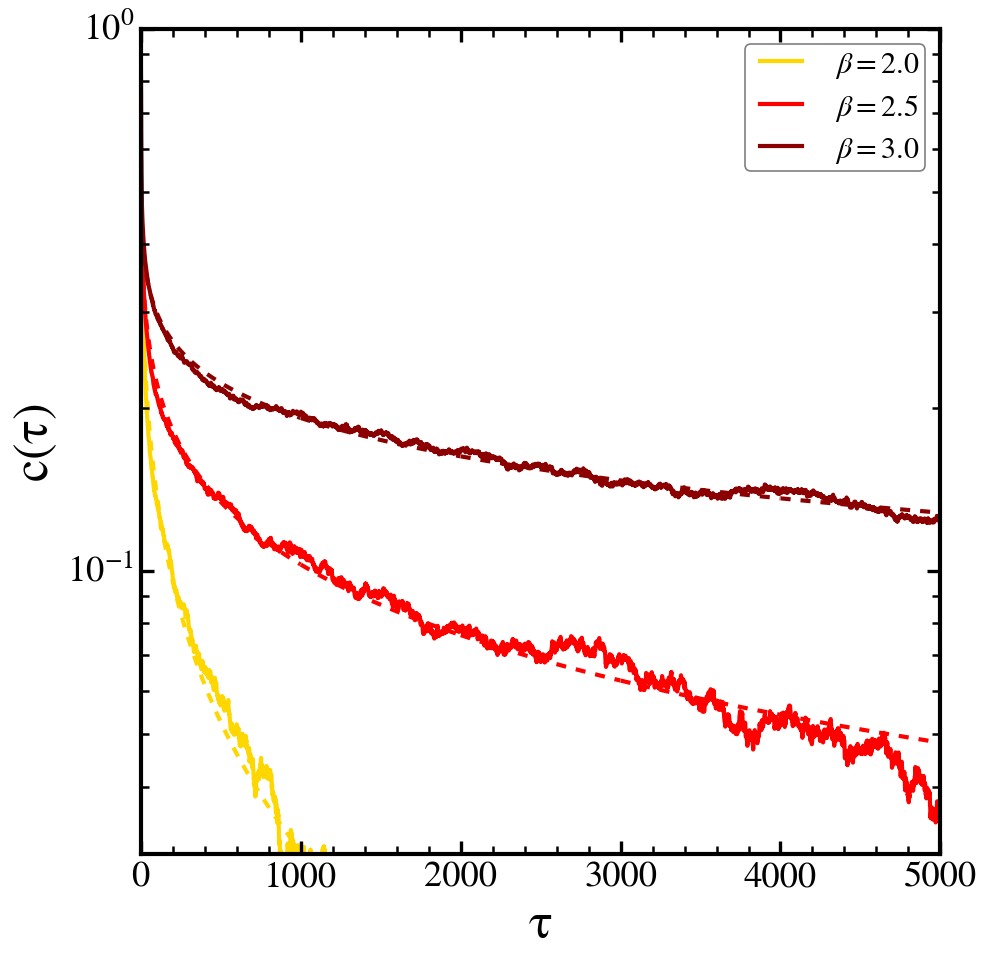

In [54]:
label1 = [rf"$\beta={beta}$" for beta in betas]

plt_acf(ac_betas_1nn, label1, log_scale=False, xlim=(0, 5000), ylim=(0.03, 1), fit=True, save=True)


#### Histograms $E/N$ varying $t_A$

Histograms of $4 \cdot 10^5$ configuration energies per spin $E/N$. The energies distribution for different annealing time $t_A$ show a clear shift to the lower-energy configuration when the annealing time increases Furthermore, with the longest annealing time D-Wave system sample configuration almost in the ground state (GS), even if the quantum annealer never reaches it. The data are obtained from the D-Wave quantum system after setting the annealing time, using several batches due the time constrains of a single D-Wave job. The horizontal red line is the ground state, computed using the McGroundstate solver.


1 $\mu$s
E: -0.7021283618736106 ± 2.090670165483138e-05
min: -0.7433134379818167 (1 occurance(s))                                                                    (s))

10 $\mu$s
E: -0.7211725082190017 ± 1.4668936649154495e-05
min: -0.7511945731648754 (1 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -0.7320812975269184 ± 1.1506537873615045e-05
min: -0.7534729061392554  (1 occurance(s))


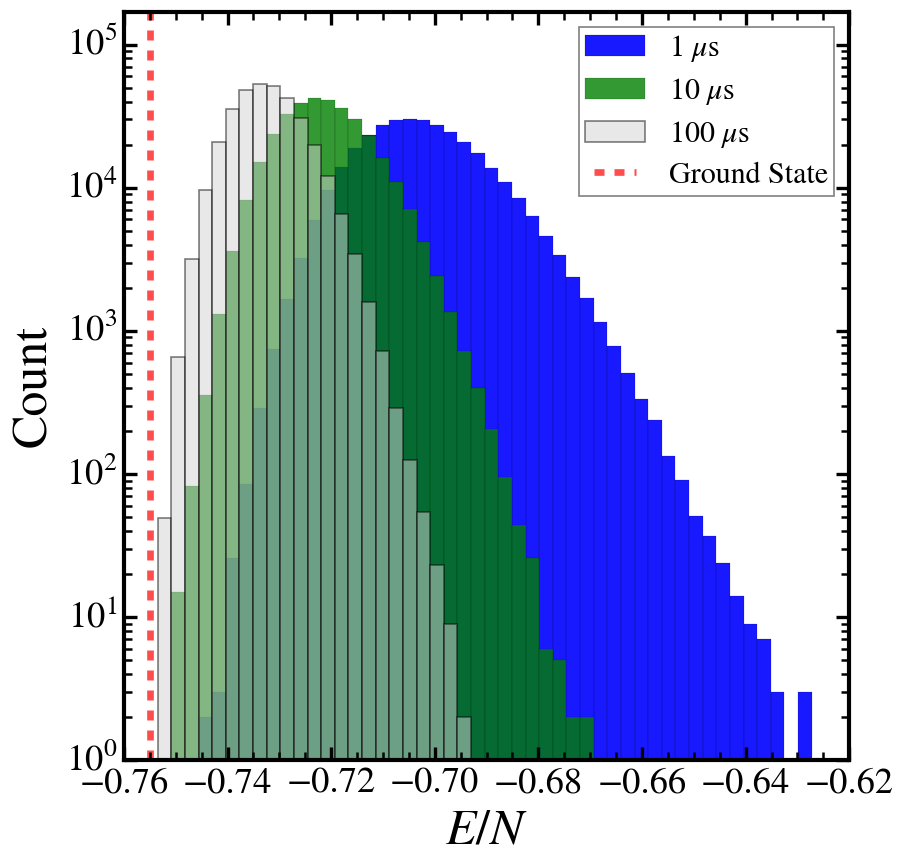

In [69]:
plot_hist(dwave_datasets_1nn[:2], couplings_path_1nn, dwave_datasets_1nn[2], 
        ground_state=ground_state_1nn, 
        labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=False)


#### $E/N$ as a function of $\beta$



##### Neural Monte Carlo

The Neural Monte Carlo simulations (N-MCMC) for 484 spins becomes hard to perform due the D-Wave bias. We can only reconstruct the thermodynamics at higher β since the D-Wave sample are shifted to the lowest energies. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

In [ ]:
betas_neural = np.linspace(2., 4, 21)
betas = np.linspace(1., 4, 31)

single_block_size = 6000
hybrid_block_size = 4000
neural_block_size = 2000
skip_single = 50000
skip_hybrid = 20000
skip_neural = 0

neural_eng_1nn = []
for beta in betas_neural:
    _, eng, _ = neural_mcmc(beta, 1000000, made_data_1nn[2], couplings_path_1nn, model='made', disable_bar=True)
    neural_eng_1nn.append(eng/484)
neural_eng_1nn = np.asarray(neural_eng_1nn)

single_error_1nn = get_errorbar(single_engs_long_1nn, single_block_size, skip_single)

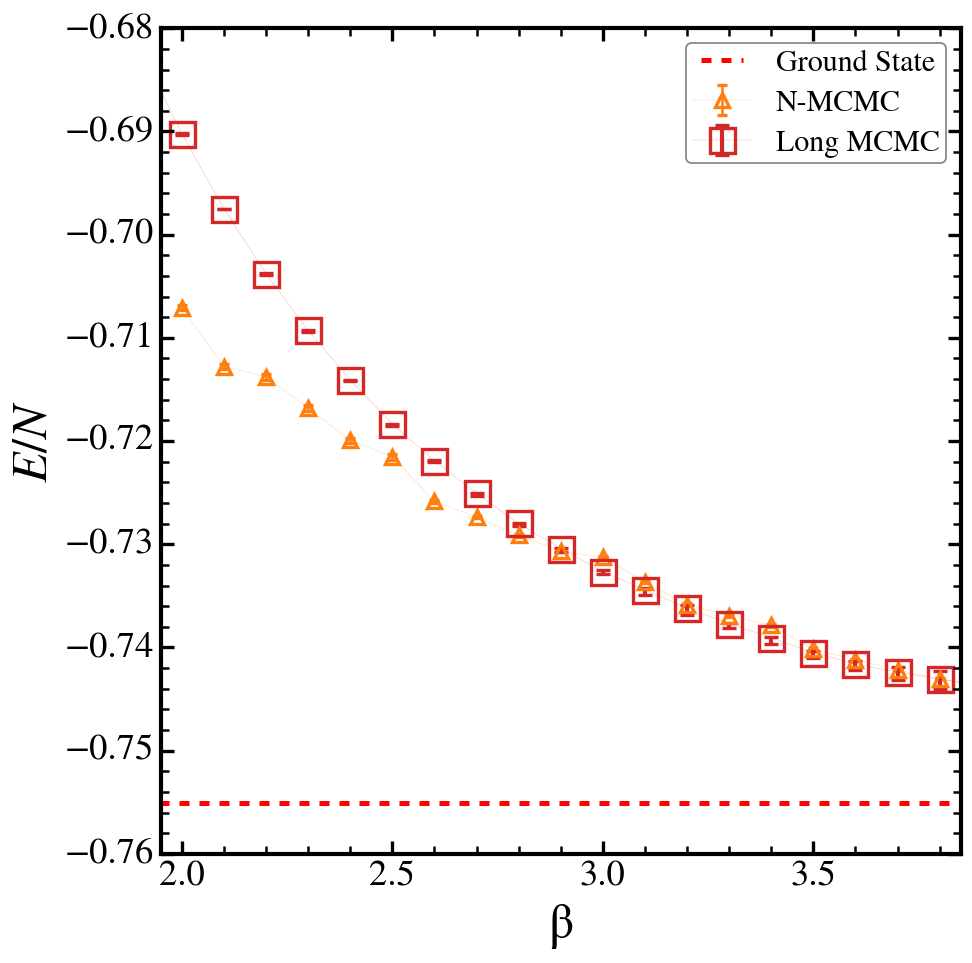

In [68]:
plt.errorbar(betas_neural, neural_eng_1nn.mean(1), yerr=block_std(neural_eng_1nn, 1000, skip=skip_neural), 
            elinewidth=1.5, linewidth=.1, marker='^', color='tab:orange', fillstyle='none', markersize=8, markeredgewidth=2,
            label=r"N-MCMC")
plt.errorbar(betas, (single_engs_long_1nn[..., skip_single:].mean(axis=2).mean(axis=0).tolist()[:-10]), 
            yerr=single_error_1nn[:, :-10], elinewidth=2.5, linewidth=.1, marker='s', color='tab:red', 
            fillstyle='none', markersize=15, markeredgewidth=2, capsize=4, label=r"Long MCMC")


plt.hlines(ground_state_1nn, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', 
           label="Ground State", linewidth=3)


plt.xlim(1.95, 3.85)
plt.ylim(-0.76, -0.68) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_neural.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_neural.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


##### Hybrid Monte Carlo

The new hybrid Monte Carlo (H-MCMC) gives good results for every temperature, without changing the dataset. In the plot above we used a D-Wave dataset obtained at annealing time $T_{a} = 100 \mu s$ and we focused in the range $\beta \in [1,4]$, which is already a challenging temperature for a single spin-flip MCMC. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

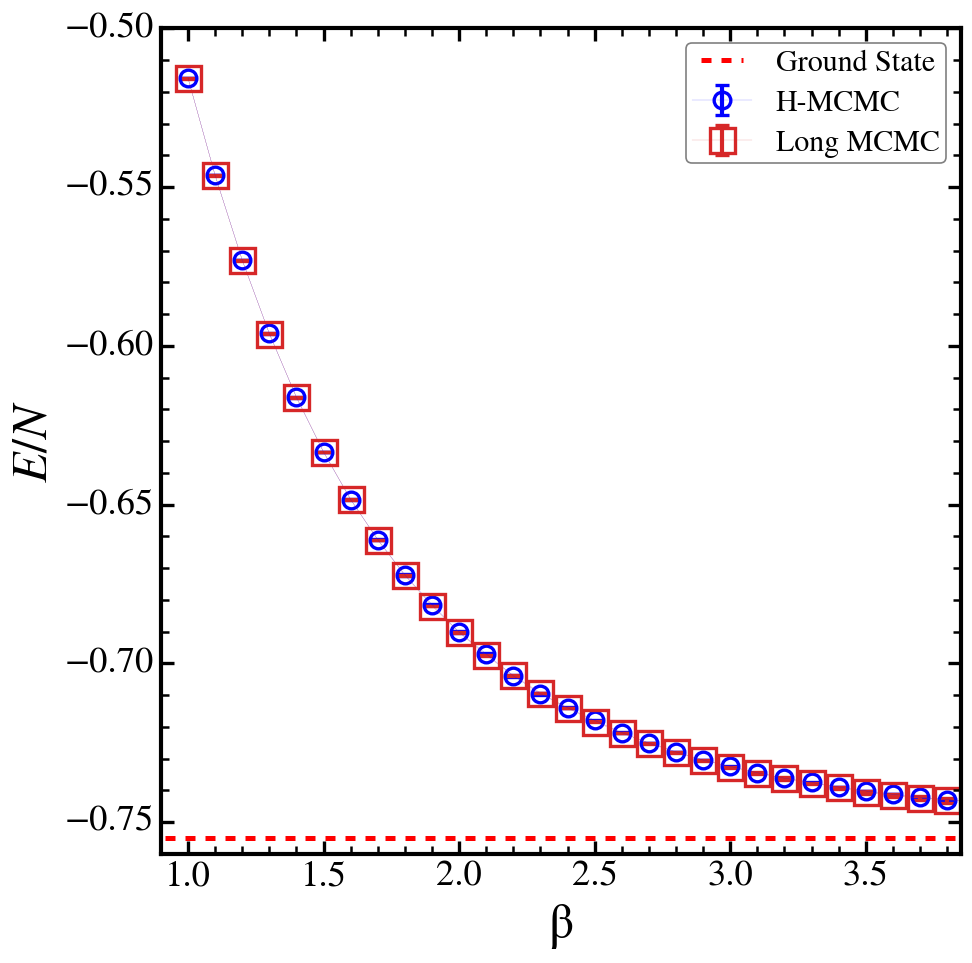

In [74]:
plt.errorbar(betas, np.asarray(eng_seq_hybrid_1nn)[...,skip_hybrid:].mean(1), 
            yerr=block_std(eng_seq_hybrid_1nn, hybrid_block_size, skip=skip_hybrid), 
            elinewidth=2.5, linewidth=.1, marker='o', fillstyle='none', markersize=10, 
            markeredgewidth=2, capsize=4, label=r"H-MCMC")
plt.errorbar(betas, (single_engs_long_1nn[..., skip_single:].mean(axis=2).mean(axis=0).tolist()[:-10]), 
            yerr=single_error_1nn[:, :-10], elinewidth=2.5, linewidth=.1, marker='s', color='tab:red', 
            fillstyle='none', markersize=15, markeredgewidth=2, capsize=4, label=r"Long MCMC")


plt.hlines(ground_state_1nn, xmin=0.4, xmax=4.4, colors='red', linestyles='dashed', 
           label="Ground State", linewidth=3)


plt.xlim(0.9, 3.85)
plt.ylim(-0.76, -0.5) 

plt.ylabel(r"$E/N$")
plt.xlabel(r"$\mathrm{\beta}$")

plt.legend()

plt.savefig(
    "images/energy-beta_hybrid.png",
    edgecolor='white', 
    bbox_inches='tight', 
    transparent=False
)
plt.savefig(
    "images/energy-beta_hybrid.eps",
    edgecolor="white",
    bbox_inches="tight",
    format="eps",
)


### D-Wave settings

The mapping between the Ising model of our Hamiltonian is not one to one into the Quantum Annealer, mainly because the two topologies could be different. Thus D-Wave uses an embedding procedure to assign each variable in the user's Hamiltonian to one or more qubits in its system. When more than one qubit is used to encode a variable, we have a chain. Every qubit in a chain has a strong coupling with its neighbors, therefore they act most of the time as a single variable. Nevertheless, sometimes some chains break and the qubits take on different values. In this case, the value attributed to the original variable is obtained through majority voting. 

To avoid the chain breaking, which leads to non-physical solutions, one can tune the `chains_strength` parameter in the D-Wave sampler. If the `chains_strength` is too large than the original problem couplings, the intra-chain couplings become predominant in the Hamiltonian, thus the annealer will optimize a wrong Hamiltonian. Otherwise, if the `chains_strength` is too small, several chain breaks can lead to configuration with lower energy than the original Hamiltonian's ground state. 

Moreover, the distribution used to sample the couplings plays an important role in the effectiveness of the annealing procedure. In the following we show some analysis on the D-Wave system.

In [3]:
dwave_path = "data"
rnds = ["uniform", "gaussian", "binary"]
strengths = np.linspace(0.5, 4, 15)

# uniform-couplings properties
uniform_ground_state = -0.7550297905
uniform_dwave_default = 1.5828847157168355
# gaussian-couplings properties
gaussian_ground_state = -1.2769078779999998 
gaussian_dwave_default = 2.7174204926999237
# binary-couplings properties
binary_ground_state = -1.3636342975206612
binary_dwave_default =  2.7629798143572195

In [5]:
engs = {"uniform": [], "gaussian": [], "binary": [],}
for rnd in rnds:
    for strength in strengths:
        try:
            eng = np.load(f"{dwave_path}/sweep_chains_{rnd}/dwave-engs_{strength}.npy")
        except:
            pass
        engs[rnd].append(eng)
    engs[rnd] = np.asarray(engs[rnd])

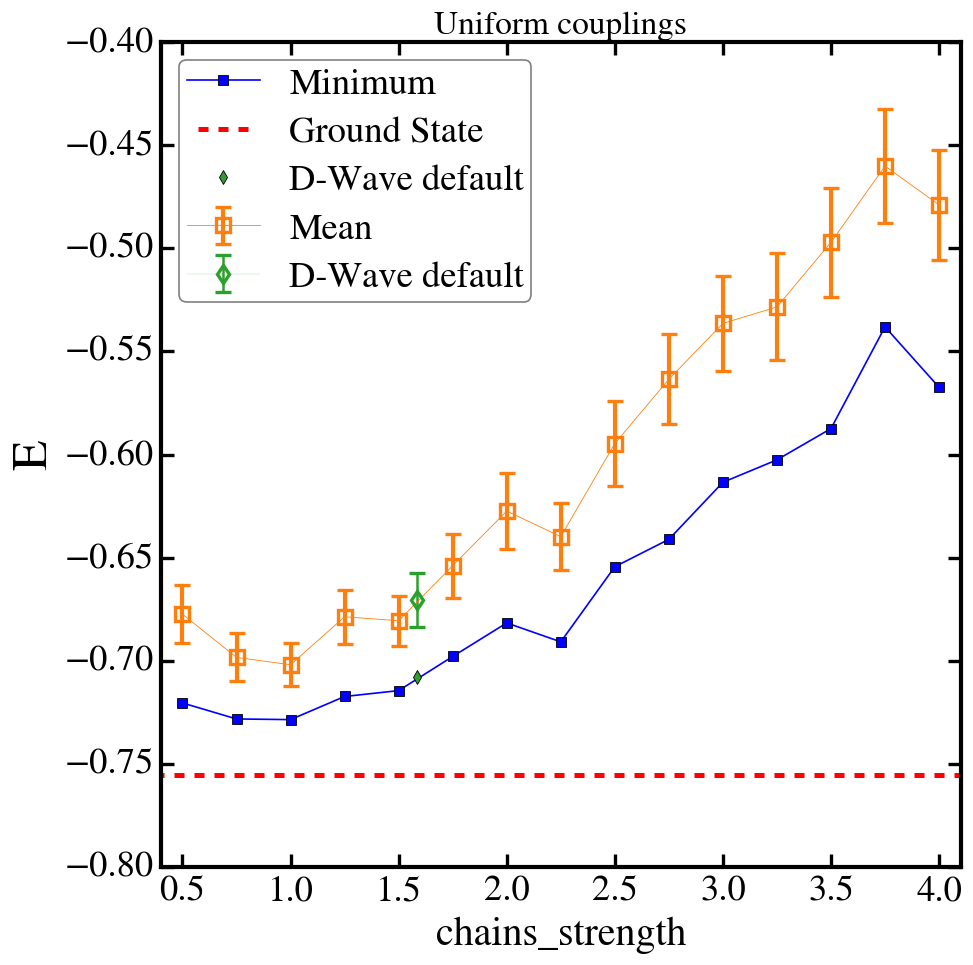

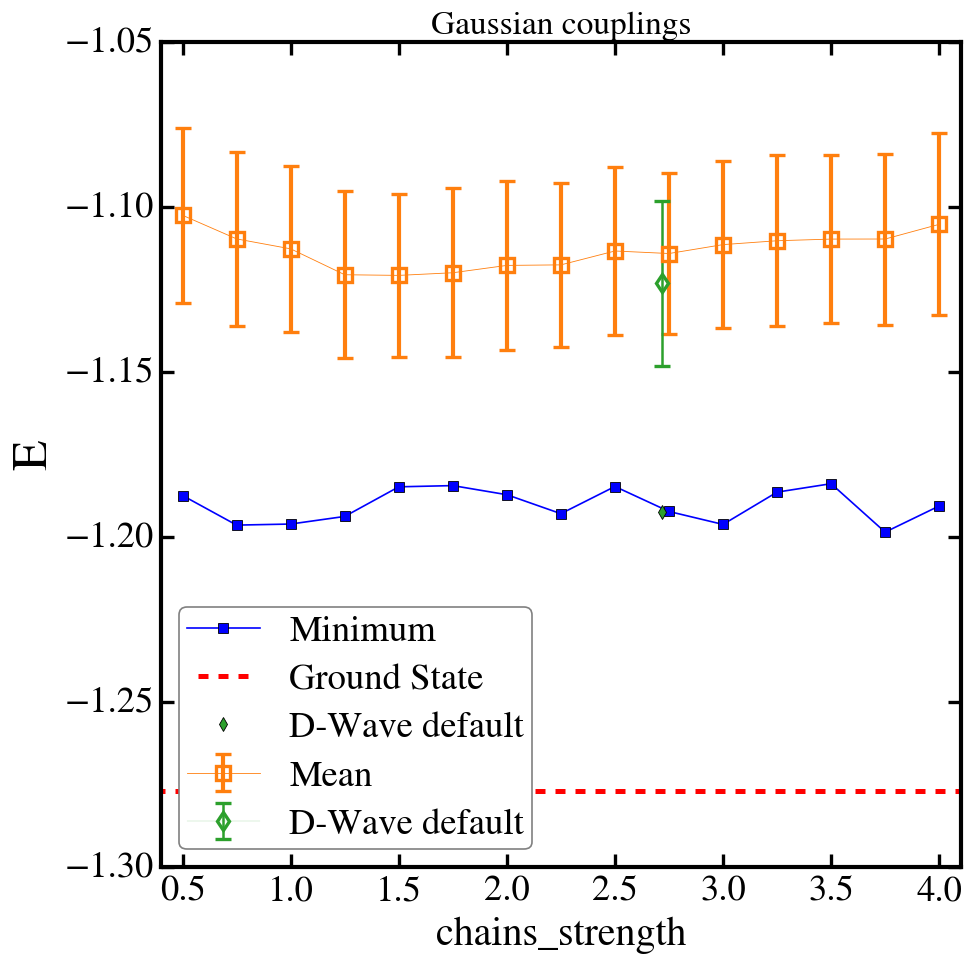

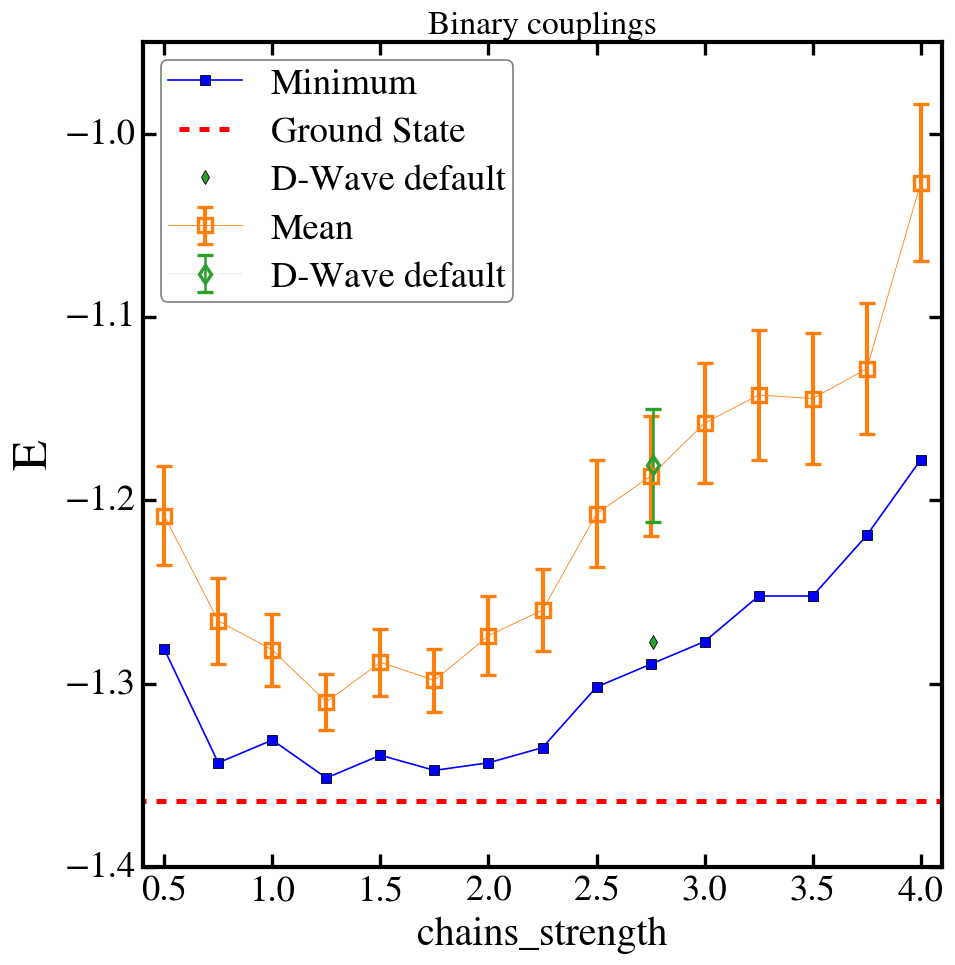

In [23]:
ground_states = [uniform_ground_state, gaussian_ground_state, binary_ground_state]
dwave_defaults = [uniform_dwave_default, gaussian_dwave_default, binary_dwave_default]
titles = ["Uniform", "Gaussian", "Binary"]

for i, rnd in enumerate(rnds):
    plt_eng_chains(engs[rnd], strengths, ground_state=ground_states[i], title=titles[i], 
                   dwave_default=dwave_defaults[i], save=False)


### Ising model 484 spins and 1NN couplings

Here and in the following we focuse on a fixed size and a particular disordered realization, which we saved in a .txt.

In [6]:
spin_side = 22
spins = spin_side**2
couplings_path_3nn = "data/couplings/484spins-uniform-3nn.txt"
ground_state_3nn = -1.0982 


#### Load Data


In [16]:
dwave_datasets_3nn = [
    "data/datasets/484-3nn-uniform-1mus/train-484spins-3nn-uniform-1mus.npy",
    "data/datasets/484-3nn-uniform-10mus/train-484spins-3nn-uniform-10mus.npy",
    "data/datasets/484-3nn-uniform-100mus/train-484spins-3nn-uniform-100mus.npy",
    ]

In [9]:
made_data_3nn = [
"data/generated/sample-500000_size-484_2022-03-01_11-09-49.npz", # 1mus 3nn
"data/generated/sample-1000000_size-484_2022-03-01_11-48-11.npz", # 10mus 3nn
"data/generated/sample-1000000_size-484_2022-03-01_11-50-00.npz", # 100mus 3nn
"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 3nn
"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 3nn
"data/generated/sample-1000000_size-484_2022-02-10_17-00-33.npz" # 100mus and 1<beta<2.5 3nn
]

labels_3nn = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
            r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
            ]


#### Acceptance Rate vs $t_A$



In [19]:
betas_3nn = np.linspace(0.5, 10, num=50)

acc_rates_3nn = []
for i, dataset in enumerate(made_data_3nn):
    acc_rate_3nn = []
    if i > 2:
        continue
    for beta in betas_3nn:
        _, _, ar = neural_mcmc(beta, 100000, dataset, couplings_path_3nn, "made", disable_bar=True)
        acc_rate_3nn.append(ar)
    acc_rates_3nn.append(acc_rate_3nn)

# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels_3nn):
    if i>2:
        continue
    labels_ar.append(label)


Performing Neural MCMC at beta=0.5
Steps: 100000 A_r=0.02%
E=-0.992813 ± 0.000013  [σ=0.004166  E_min=-1.054394]
Duration 0:00:02.948836

Performing Neural MCMC at beta=0.6938775510204082


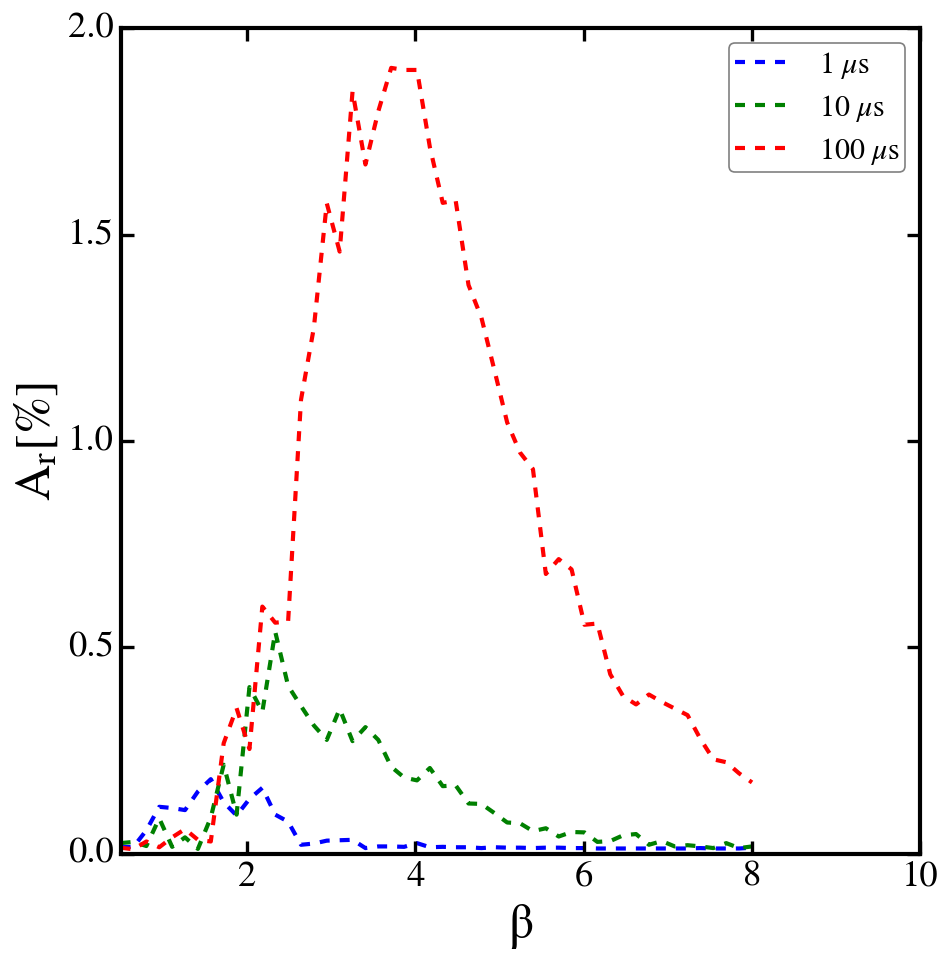

In [18]:
plt_betas_ar(acc_rates_3nn, labels_ar, betas_3nn, xlim=(0.5, 10), save=False)


#### Histograms $E/N$ varying $t_A$

Histograms of $4 \cdot 10^5$ configuration energies per spin $E/N$. The energies distribution for different annealing times show a clear shift to the lower-energy configuration when the annealing time increases Furthermore, with the longest annealing time D-Wave system sample configuration almost in the ground state (GS), even if the quantum annealer never reaches it. The data are obtained from the D-Wave quantum system after setting the annealing time, using several batches due the time constrains of a single D-Wave job. The horizontal red line is the ground state, computed using the McGroundstate solver.


1 $\mu$s
E: -1.0475328561010135 ± 2.328839823441583e-05
min: -1.0969759706962803 (1 occurance(s))                                                                    (s))

10 $\mu$s
E: -1.0675086354127463 ± 1.8316617586060988e-05
min: -1.0970910593355352 (1 occurance(s))                                                                    (s))

100 $\mu$s eng
E: -1.0782929306423352 ± 1.4771195420663153e-05
min: -1.0981585421367768  (1 occurance(s))


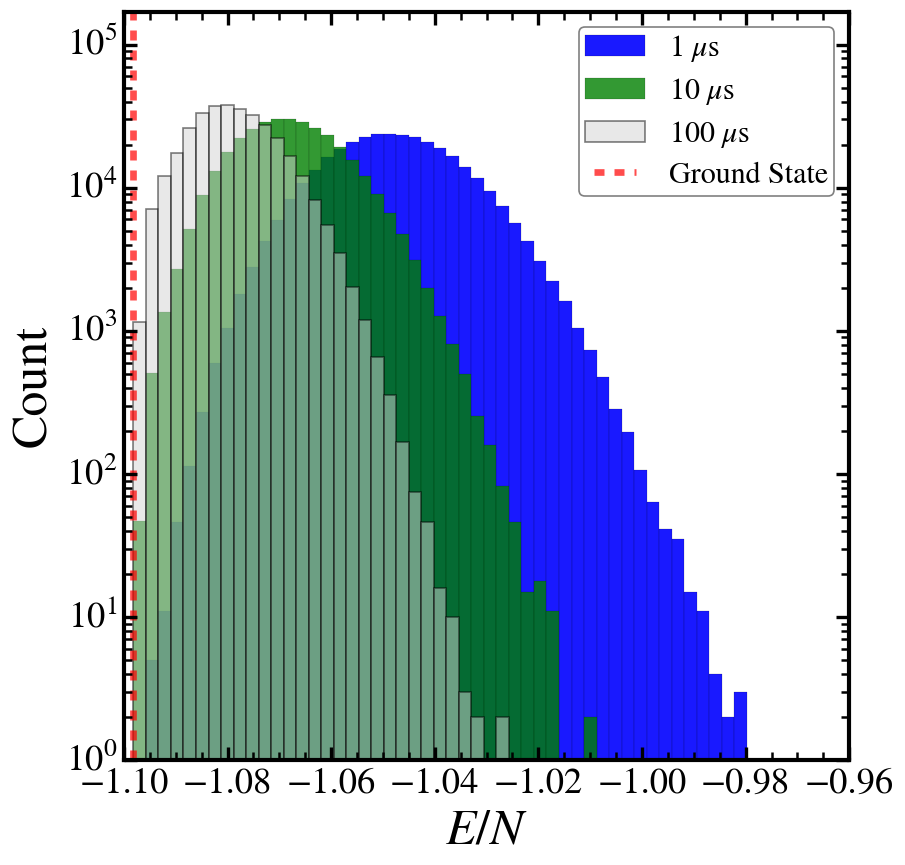

In [17]:
plot_hist(dwave_datasets_3nn[:2], couplings_path_3nn, dwave_datasets_3nn[2], 
        ground_state=ground_state_3nn, 
        labels=[r"1 $\mu$s", r"10 $\mu$s", r"100 $\mu$s"], save=False)